In [2]:
%matplotlib inline

import os
import sys
import copy
import time
from array import array
import numpy as np
np.seterr(over='ignore')
import scipy as sp
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.interpolate import RegularGridInterpolator
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from ipywidgets import interact, interactive, fixed, FloatSlider

# autoreload user modules functionality
%load_ext autoreload
%autoreload 2

# VarClump functions
sys.path.append('../lib/')
from utils import *
from graph import *
from points_generation import *
from initial_guess import *
from variational import *
from gmr import *

# pycupid
from pycupid import *

# just for presentation
import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generating a synthetic example

Gaussian function:
$$
f(x,y) = A \cdot \exp \left(- \left( a(x-x_0)^2 - 2b(x-x_0)(y-y_0) + c(y-y_0)^2 \right) \right)
$$

In [64]:
def gaussian2D(A, mu, sig, dims=(200,200)):
    x = np.linspace(0., 1., dims[0]+2)[1:-1]
    y = np.linspace(0., 1., dims[1]+2)[1:-1]
    X,Y = np.meshgrid(x,y)
    _X = X-mu[0]
    _Y = Y-mu[1]
    a = sig[0]; b=sig[1]; c=sig[2]
    return A * np.exp(- (a*_X**2 - 2*b*_X*_Y + c*_Y**2))

In [278]:
g0 = gaussian2D(0.20, [0.7,0.3], [400,20,200])
g1 = gaussian2D(0.20, [0.63,0.35], [600,75,50])
g2 = gaussian2D(0.22, [0.52,0.38], [100,20,200])
g3 = gaussian2D(0.13, [0.6,0.2], [800,10,900])
g4 = gaussian2D(0.1, [0.78,0.3], [1000,20,900])
g5 = gaussian2D(0.1, [0.72,0.42], [800,30,1000])
g6 = gaussian2D(0.15, [0.40,0.75], [100,20,70])
g7 = gaussian2D(0.19, [0.25,0.8], [80,20,100])


dims = (200,200)
noise_level = 0.005
noise = noise_level * np.random.randn(*dims)

data = g0+g1+g2+g3+g4+g5+g6+g7+noise
data -= data.min()
data /= data.max()

x = np.linspace(0., 1., data.shape[0]+2, endpoint=True)[1:-1]
y = np.linspace(0., 1., data.shape[1]+2, endpoint=True)[1:-1]
dfunc = RegularGridInterpolator((x,y), data, method='linear', bounds_error=False, fill_value=0.)

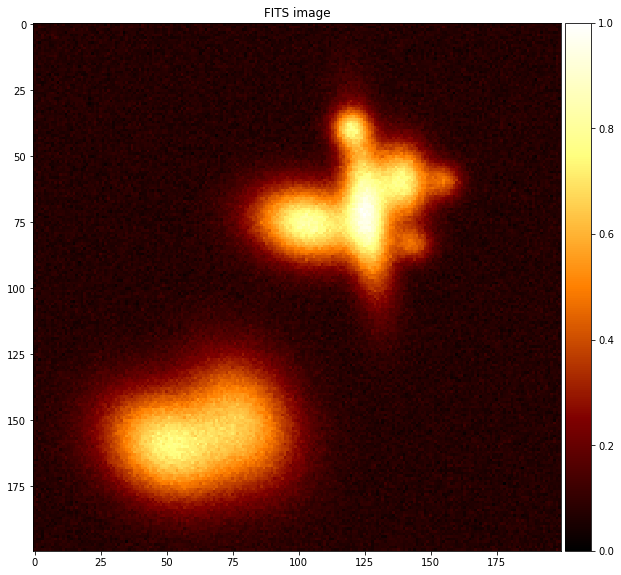

In [279]:
image_plot(data)

In [280]:
base_level = estimate_rms(data)
interact(thresholded_image_plot, data=fixed(data), level=FloatSlider(min=base_level,max=1.,step=0.01,value=base_level))

<function graph.thresholded_image_plot>

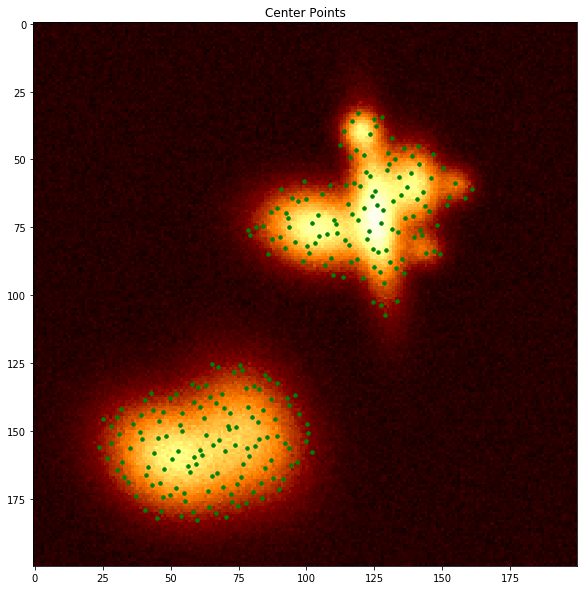

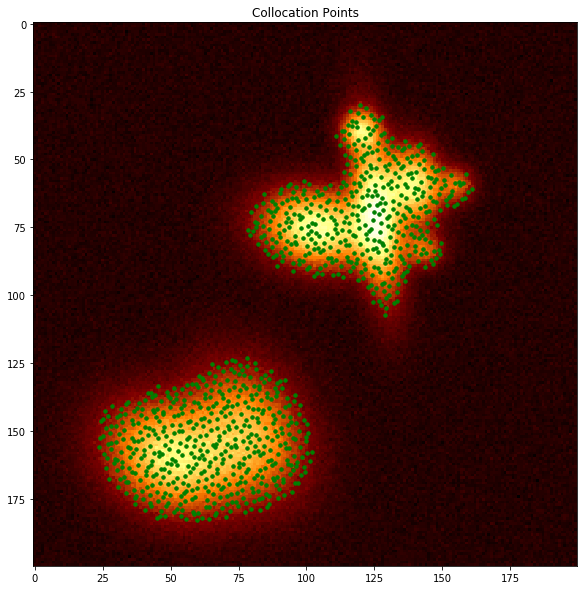

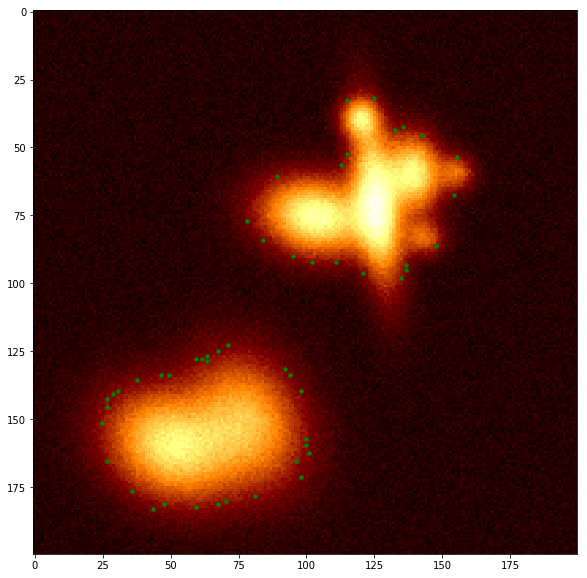

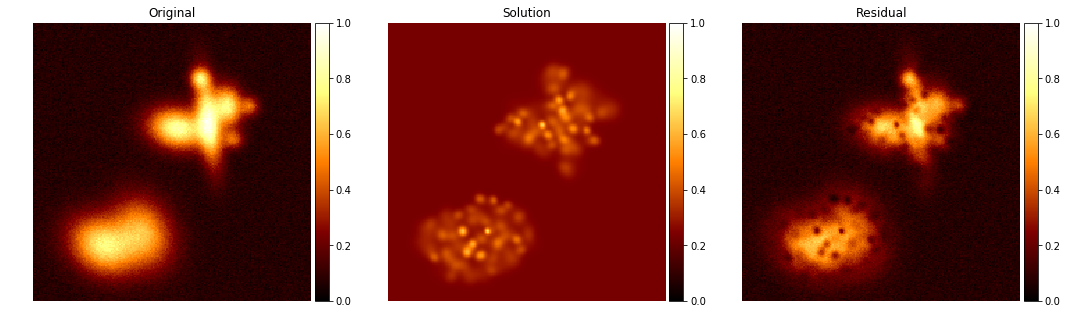

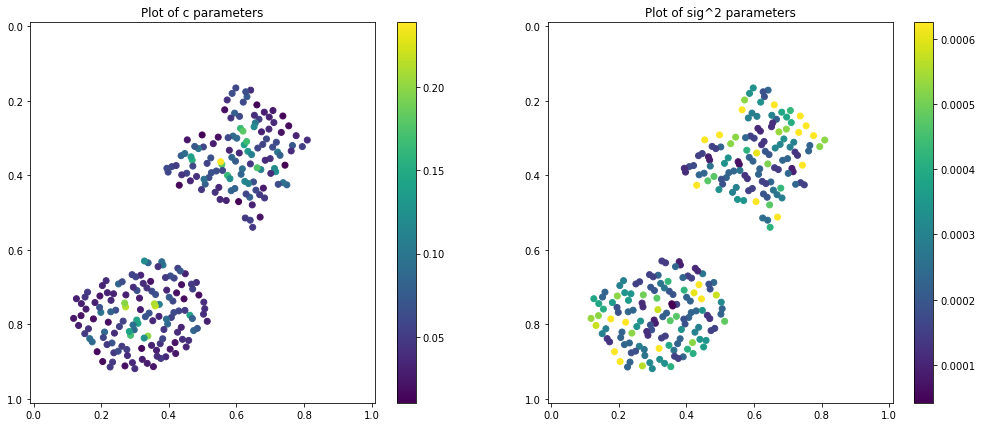

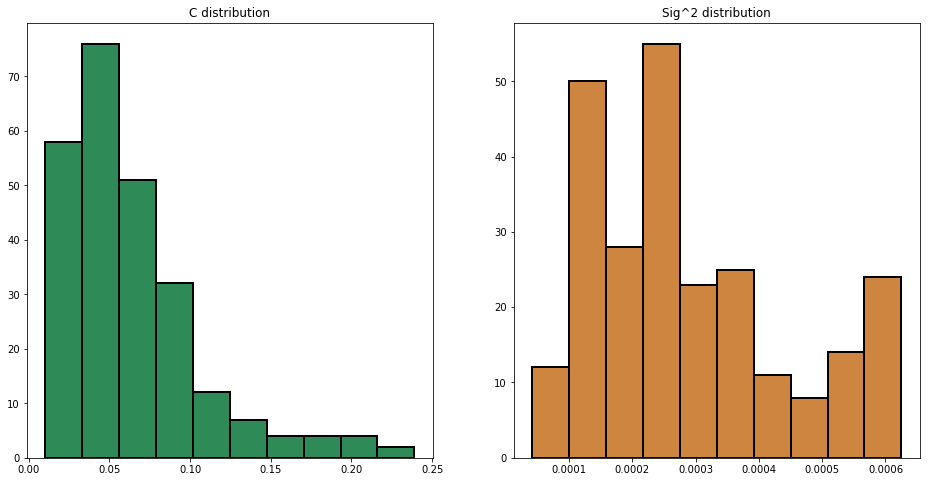

In [283]:
Nc = 250
Nb = int(0.2*Nc) #20% of boundary pixels
Ne = 4*Nc - Nb

method=2

if method==1:
    center_points = random_centers_generation(data, Nc, base_level=base_level, power=3.)
    collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
    boundary_points = boundary_points_generation(data, base_level, Nb)
elif method==2:
    # points generation
    points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
    center_points = points[0:Nc]
    collocation_points = points[0:Ne]
    boundary_points = boundary_points_generation(data, base_level, Nb)   

# right format
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]

# visualizing the choosen points
points_plot(data, center_points=center_points, title="Center Points")
points_plot(data, center_points=collocation_points, title="Collocation Points")
points_plot(data, boundary_points=boundary_points, title="Boundary Points")

# Initial parameters estimation
minsig = ( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
maxsig = 30*minsig
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')

solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
params_plot(c0, sig0, xc, yc)
params_distribution_plot(c0, sig0)


elm01 = ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=1., lamb1=1., d1psi1=d1psi, 
                d1psi2=d1psi, d2psi2=d2psi, base_level=base_level, pix_freedom=1., minsig=minsig, maxsig=maxsig)


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: False
status: 5
message: Number of calls to function has reached maxfev = 100100.
nfev: 100114

Residual stats:
Residual RMS: 0.02057615301613028
Residual Variance: 0.0004179373984018228
Flux Lost: 0.018758502963081642
Flux Addition: 0.013878557496566237
psi1(u-f): 0.326222606292799
Exceeded Pixels: 3321
Sharpness: 192.87700030379156
psi2(grad u): 2.03933138831949
Total elapsed time: 285.07839703559875 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.034474697462013905
Mean min distance between collocation and center points: 0.010950910752680064

Homogeneity of solution:
Mean min distance in the (standarized) parameters space: 0.09125590724702455
Max min distance in the (standarized) parameters space: 0.2651655731893552


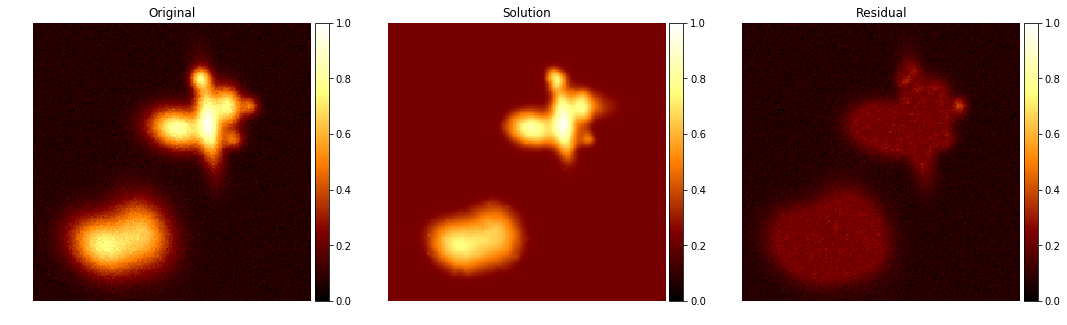

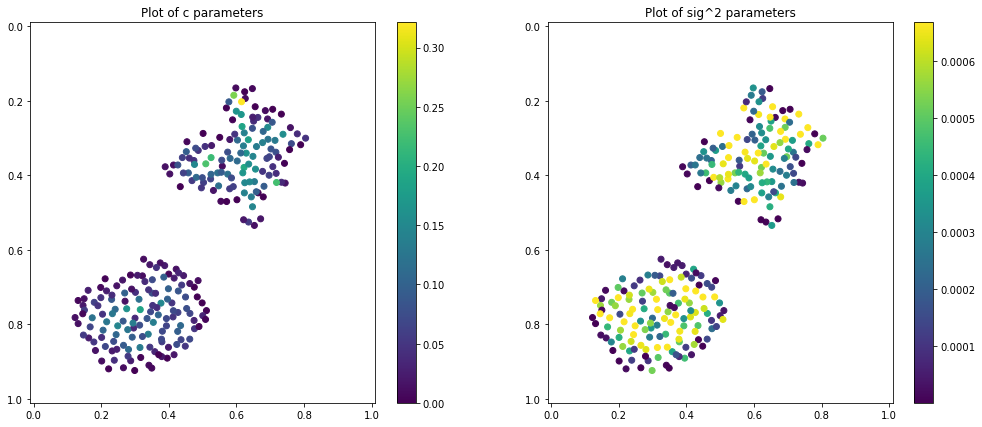

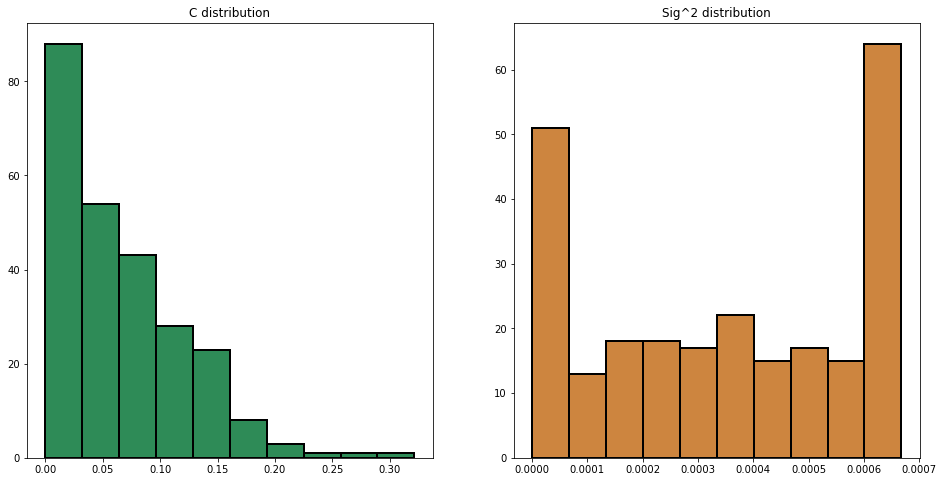

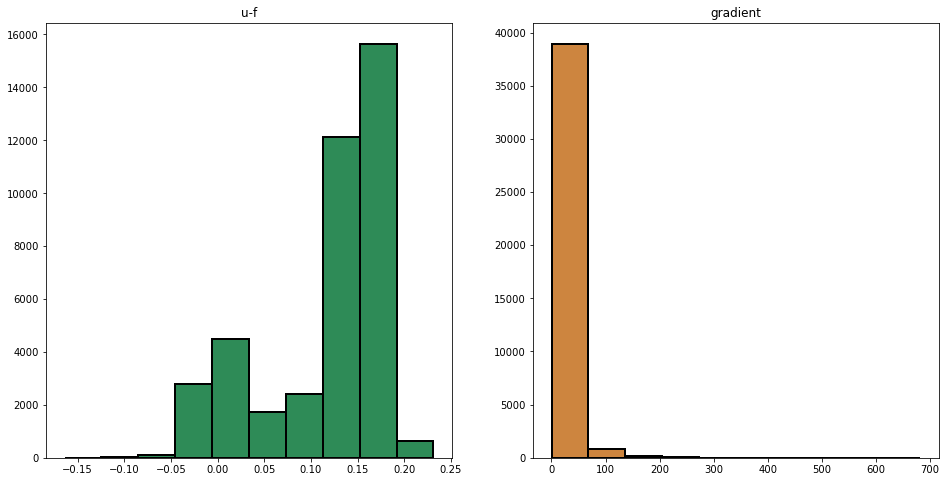

In [284]:
nfev = 100*(len(elm01.get_params())+1)
elm_solver(elm01, method='standard', max_nfev=nfev)

In [285]:
elm01.prune()
xc, yc, c, sig = elm01.get_params_mapped()
w = elm01.get_w()
mu = np.vstack([xc, yc]).T

In [286]:
components_dict01, isd_hist, kl_hist = gaussian_reduction(w, mu, sig, n_comp=1, metric='KL', verbose=True)

Merged components 18 and 160 with 1.3559541665651186e-07 KL dist and 2.594104439039686e-12 ISD dist
Merged components 56 and 194 with 1.3734784436858507e-07 KL dist and 6.90565659641651e-13 ISD dist
Merged components 61 and 215 with 3.1882736212227446e-07 KL dist and 2.1234731736250985e-11 ISD dist
Merged components 76 and 147 with 4.512077113478196e-07 KL dist and 7.147837667093745e-10 ISD dist
Merged components 49 and 183 with 4.648192152783648e-07 KL dist and 1.8921372744656695e-11 ISD dist
Merged components 155 and 199 with 4.840639627526615e-07 KL dist and 1.1772635527900984e-10 ISD dist
Merged components 68 and 201 with 5.763742676023743e-07 KL dist and 4.433876507809376e-11 ISD dist
Merged components 13 and 211 with 7.72897446758142e-07 KL dist and 2.1002935868623865e-10 ISD dist
Merged components 39 and 171 with 9.563817146969965e-07 KL dist and 4.618734479767837e-10 ISD dist
Merged components 100 and 188 with 1.0925873551013292e-06 KL dist and 1.1233687473387716e-09 ISD dist
M

Merged components 58 and 77 with 2.7176919565091457e-05 KL dist and 6.393372894411466e-09 ISD dist
Merged components 0 and 31 with 2.8514634387152285e-05 KL dist and 4.0555171390853394e-10 ISD dist
Merged components 5 and 97 with 2.880608848275447e-05 KL dist and 1.2004003637806096e-07 ISD dist
Merged components 10 and 73 with 2.921584182710897e-05 KL dist and 1.1746489323598058e-07 ISD dist
Merged components 22 and 50 with 3.0213965018083093e-05 KL dist and 1.3335178158179026e-09 ISD dist
Merged components 63 and 101 with 3.0276380531553648e-05 KL dist and 2.024621464874038e-07 ISD dist
Merged components 22 and 56 with 3.039297889805134e-05 KL dist and 5.920132120514315e-08 ISD dist
Merged components 14 and 98 with 3.105070678121431e-05 KL dist and 8.171380656074248e-08 ISD dist
Merged components 12 and 46 with 3.2360964236786494e-05 KL dist and 1.9334240080049016e-07 ISD dist
Merged components 16 and 67 with 3.310910479075043e-05 KL dist and 1.2867736763324256e-08 ISD dist
Merged com

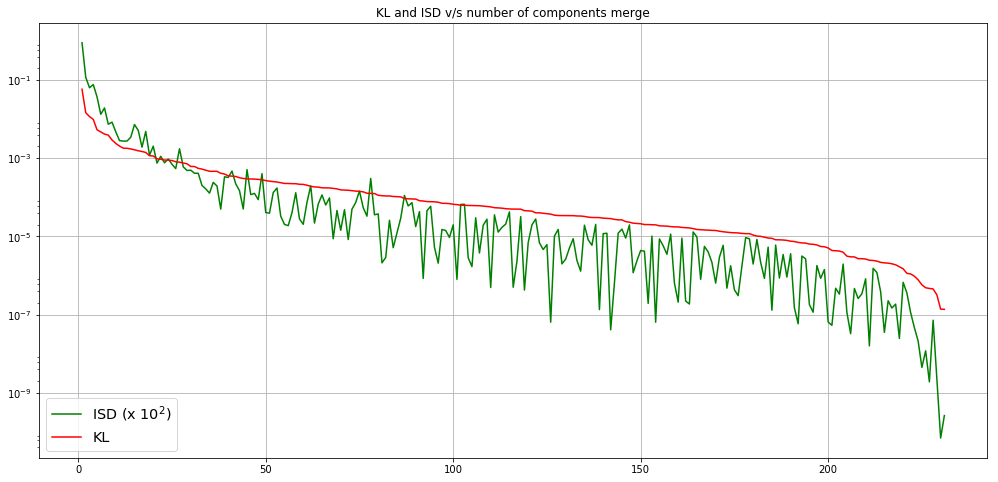

In [287]:
ncomp = list(range(len(isd_hist),0,-1))
plt.figure(figsize=(17,8))
plt.semilogy(ncomp, 1e2*isd_hist, "g-", label='ISD (x$\ 10^2$)')
plt.semilogy(ncomp, kl_hist, "r-", label='KL')
plt.title("KL and ISD v/s number of components merge")
plt.grid()
plt.legend(loc='lower left', fontsize="x-large")
plt.show()

In [288]:
interact(components_plot, elm=fixed(elm01), data=fixed(data), components_dict=fixed(components_dict01), n_comp=(1,20), dims=fixed(data.shape), resolution=fixed(1), n_levels=fixed(5))

<function graph.components_plot>

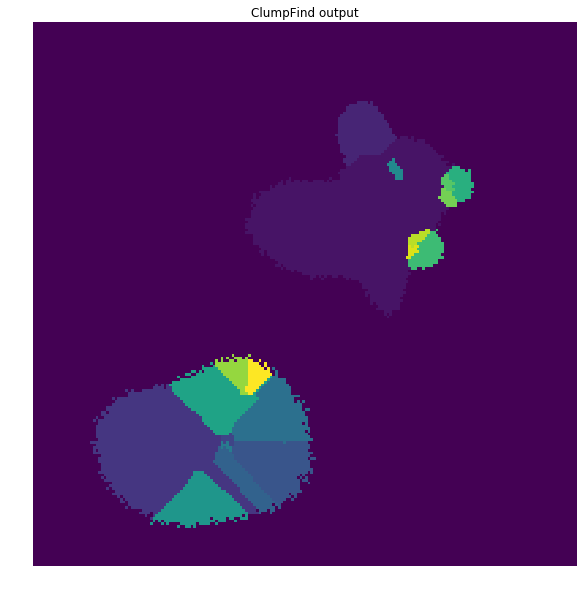

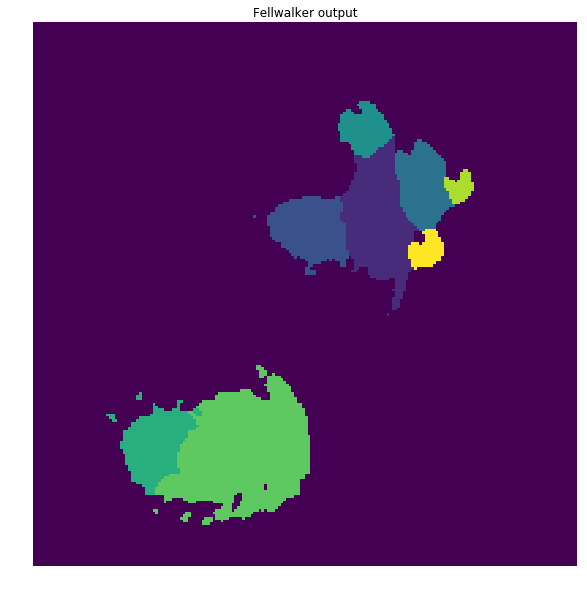

In [289]:
out_cf = clumpfind(data, 0.5*base_level)
out_cf[out_cf==out_cf.min()] = 0.

plt.figure(figsize=(10,10))
plt.title('ClumpFind output')
plt.imshow(out_cf.T)
plt.axis('off')
plt.show()

out_fw = fellwalker(data, 0.5*base_level)
out_fw[out_fw==out_fw.min()] = 0.

plt.figure(figsize=(10,10))
plt.title('Fellwalker output')
plt.imshow(out_fw.T)
plt.axis('off')
plt.show()